## Regress out cell counts from all features on full dataset

In [1]:
import sys
sys.path.append('../1.load')

import numpy as np
import pandas as pd

from preprocess import preprocess_profiles, config
from correct_position_effect import subtract_well_mean, mad_robustize_col, regress_out_cell_counts

import seaborn as sns
from matplotlib import pyplot as plt

#### Load profiles

In [2]:
CC_COL = "Cells_Count"

In [3]:
ann_profiles = pd.read_parquet("../1.load/output/raw_filtered_profiles.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.535004,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,95.772003,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,135.899994,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,88.174004,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,94.418999,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86686,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,50.188999,50.206001,47.050999,47.171001,46.860001,47.014000,47.410000,48.515999,47.205002,48.396000
86687,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,53.575001,52.326000,50.000999,50.161999,49.946999,50.459000,50.619999,51.743999,50.601002,52.030998
86688,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,81.460999,80.575996,76.153000,76.277000,76.153999,76.739998,76.920998,78.600998,76.968002,79.113998
86689,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,39.830002,39.647999,37.362999,37.421001,37.465000,37.610001,37.636002,38.500000,37.762001,38.643002


Text(0.015440746879061393, 5, '0.015')

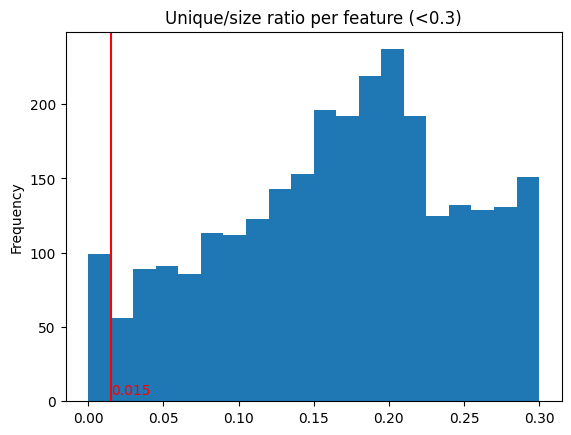

In [4]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature (<0.3)")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Explore correlations with cell counts

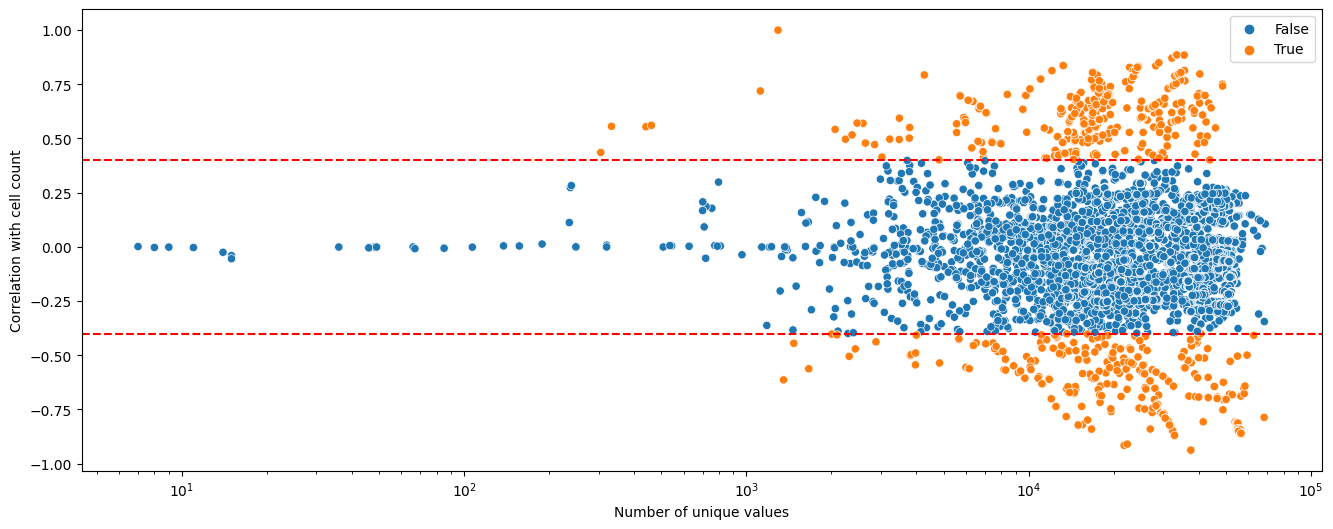

In [5]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")

plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### List low unique ratio features that are correlated with cell count

No features that have nigh correlations and less than 1000 unique values

In [6]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if (feature_corr > corr_cutoff or feature_corr < -corr_cutoff) and ann_profiles[feature].nunique() < 1000:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Nuclei_Correlation_Manders_AGP_RNA: 0.5543203429484646
Nuclei_Correlation_Manders_DNA_RNA: 0.43553866259617274
Nuclei_Correlation_Manders_ER_RNA: 0.5561606066011304
Nuclei_Correlation_Manders_Mito_RNA: 0.5608393069407439


#### Regress out cell counts only from features that have >100 unique values

In [7]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, min_unique=100)
ann_profiles

  0%|          | 0/4762 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ann_profiles.to_parquet("output/profiles_cc_adjusted.parquet")

#### Check if cell count has correlation above 0.5 with any feature

In [ ]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if np.abs(feature_corr) > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Cells_Count: 1.0


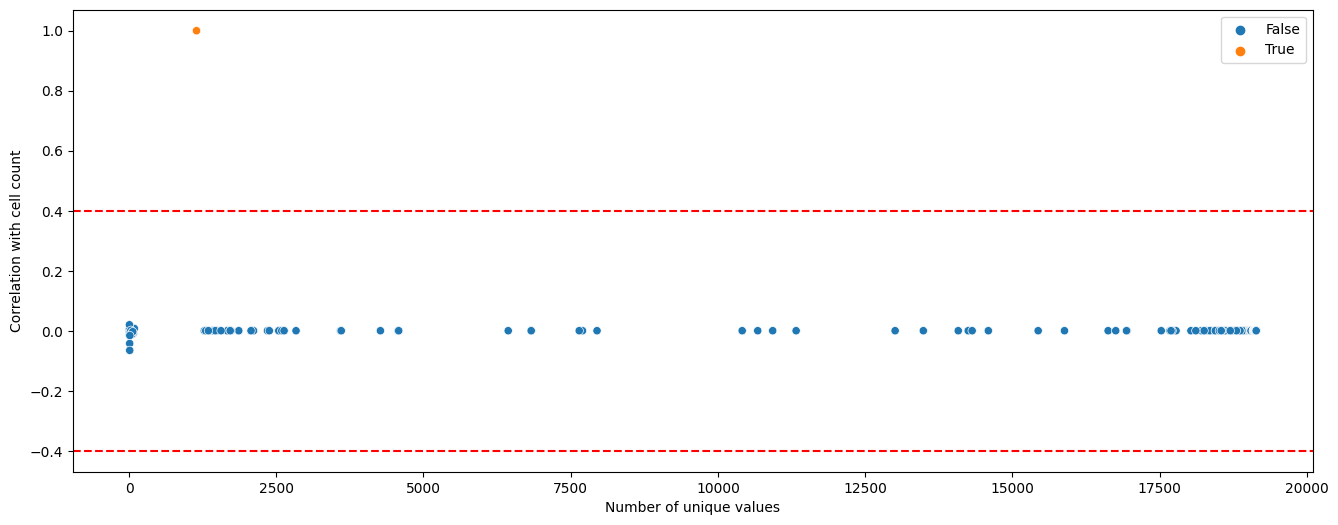

In [ ]:
corr_cutoff = 0.4

plt.figure(figsize=(16, 6)) 
sns.scatterplot(
    data=ann_profiles.filter(regex="^(?!Metadata_)"),
    x=ann_profiles.filter(regex="^(?!Metadata_)").nunique(),
    y=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]),
    hue=ann_profiles.filter(regex="^(?!Metadata_)").corrwith(ann_profiles["Cells_Count"]).abs() > corr_cutoff,
    )
plt.xlabel("Number of unique values")
plt.ylabel("Correlation with cell count")

plt.xscale("log")


plt.axhline(y=corr_cutoff, color="red", linestyle="--")
plt.axhline(y=-corr_cutoff, color="red", linestyle="--")

plt.show()

#### Plot the ratio of unique values / size for cell count

This is the reason it gets filtered by `feature_select`

Text(0.059862097785206854, 5, '0.060')

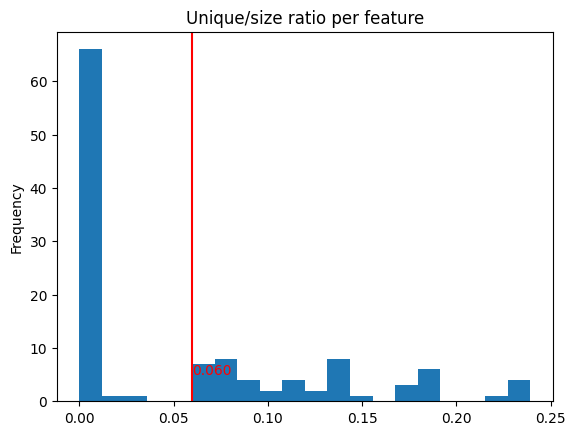

In [ ]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")
plt.text(unique_ratio["Cells_Count"], 5, f"{unique_ratio['Cells_Count']:.3f}", color="red")

#### Preprocess and save CC-corrected subset

In [ ]:
ann_profiles = preprocess_profiles(ann_profiles) 
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_01_256,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.843520,0.076629,0.320495,-0.385691,0.190393,0.455439,0.509989,-1.019058,-0.728018,-0.842900
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.553290,-1.089465,-0.339287,-1.516528,-0.441853,-0.130403,-0.575900,0.593813,0.509472,-0.214630
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.234758,-0.754398,0.077711,-0.322006,0.405521,0.628356,0.367091,0.264900,-0.726229,-0.754226
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,0.015575,-0.494212,-0.287738,-0.628006,-0.710360,-0.637044,-0.199234,-0.135215,-0.290255,0.329603
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.037950,-0.722263,-0.448482,-1.166396,-1.939791,-1.753126,-0.387831,-0.074344,0.047114,1.303154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.711637,-3.969020,-0.809173,-2.974404,-2.787182,-0.704466,0.198940,2.073704,0.223352,-0.531671
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.077464,-3.094050,-0.711135,-2.103393,-1.919127,-0.485729,0.300176,1.795613,-0.029494,-0.503798
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.488416,-3.648240,-0.653903,-2.628677,-2.837781,-0.915236,0.115573,2.372484,0.350838,0.082462
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.967861,-4.202986,-0.806160,-2.797058,-2.398970,-0.965612,0.605841,2.384358,0.194635,0.017635


In [ ]:
# check that the cell count column is still there
assert CC_COL in ann_profiles.columns

ann_profiles.to_parquet("output/profiles_cc_adjusted_preprocessed.parquet")